In [1]:
!pip install --upgrade google-cloud-bigquery

## Load data

In [2]:
from google.cloud import bigquery
import pandas as pd
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

df = pd.read_parquet("/content/drive/MyDrive/SIC_PROJECT/Data/Processed/cleaned_games.parquet")


In [5]:
df.head()

,id,genres,platforms,name,released,rating,rating_top,added,playtime,ratings_count,reviews_count,tags,rating_exceptional,rating_recommended,rating_meh,rating_skip,year
0,428704,[Indie],[PC],Super Magbot,2021-06-21,NaN,0,535,1,NaN,0,"[Singleplayer, Full controller support, 2D, Di...",0.0,0.0,0.0,0.0,2021
1,16852,"[Indie, Adventure]","[PC, macOS]",Relive,2015-10-15,NaN,0,253,1,NaN,0,"[Singleplayer, Steam Achievements, Free to Play]",0.0,0.0,0.0,0.0,2015
2,755616,"[Shooter, Adventure, Action, Platformer, Indie]","[PC, Web]",Duck Paradox,2022-03-16,NaN,0,236,1,NaN,0,"[Singleplayer, Sci-fi, Sandbox, Survival, Acti...",0.0,0.0,0.0,0.0,2022
3,19185,"[Indie, Adventure]",[PC],I must kill...: Fresh Meat,2015-11-30,NaN,0,233,1,NaN,0,"[Singleplayer, Horror, Free to Play, Early Acc...",0.0,0.0,0.0,0.0,2015
4,971889,"[Adventure, Action, RPG, Casual, Simulation, S...","[PC, Xbox Series S/X, Nintendo Switch]",Spells & Secrets,2023-11-09,NaN,0,231,2,NaN,0,"[Singleplayer, Steam Achievements, Multiplayer...",0.0,0.0,0.0,0.0,2023


In [6]:
from math import nan
df_transformed = df[df['released'] != nan]

In [7]:
# xóa cột released
df_transformed.drop(columns=["released"], inplace=True)

In [8]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9806 entries, 0 to 9805
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  9806 non-null   Int64  
 1   genres              9806 non-null   object 
 2   platforms           9806 non-null   object 
 3   name                9806 non-null   object 
 4   rating              8889 non-null   float64
 5   rating_top          9806 non-null   Int64  
 6   added               9806 non-null   Int64  
 7   playtime            9806 non-null   Int64  
 8   ratings_count       9782 non-null   float64
 9   reviews_count       9806 non-null   Int64  
 10  tags                9806 non-null   object 
 11  rating_exceptional  9806 non-null   float64
 12  rating_recommended  9806 non-null   float64
 13  rating_meh          9806 non-null   float64
 14  rating_skip         9806 non-null   float64
 15  year                9806 non-null   Int64  
dtypes: Int

## Lọc các tags ít xuất hiện

In [9]:
from collections import Counter

# Flatten tất cả tag
all_tags = []
df_transformed["tags"].dropna().apply(lambda x: all_tags.extend(x))
tag_counts = Counter(all_tags)

In [10]:
tag_counts

Counter({'Singleplayer': 8023,
         'Full controller support': 2933,
         '2D': 1869,
         'Difficult': 823,
         'Pixel Graphics': 894,
         'Controller': 487,
         'Retro': 568,
         '2D Platformer': 96,
         '2D-платформер': 93,
         'Puzzle Platformer': 59,
         'Precision Platformer': 31,
         'Steam Achievements': 5159,
         'Free to Play': 1196,
         'Sci-fi': 989,
         'Sandbox': 639,
         'Survival': 721,
         'Action-Adventure': 498,
         'Early Access': 797,
         'Cute': 536,
         'Physics': 341,
         'Side Scroller': 326,
         "Shoot 'Em Up": 295,
         'Bullet Hell': 172,
         'Time Travel': 54,
         'Science': 56,
         'Bullet Time': 36,
         'Unity': 23,
         'duck': 1,
         'adaptive-music': 1,
         'Horror': 1366,
         'Multiplayer': 3111,
         'Steam Cloud': 3141,
         'RPG': 2127,
         'Co-op': 1657,
         'cooperative': 1312,
        

In [11]:
# Giữ tag xuất hiện ít nhất 100 lần
popular_tags = [tag for tag, count in tag_counts.items() if count >= 100]

def filter_tags(tag_list):
    return [t for t in tag_list if t in popular_tags]

df_transformed["tags"] = df["tags"].apply(filter_tags)


## Tạo các feature mới

In [12]:
# Bỏ các record rating = 0 và rating = nan
df_transformed = df_transformed[(df_transformed["rating"] != 0) & (df_transformed["rating"].notna())].reset_index(drop=True)

In [13]:
import numpy as np

df_transformed["platform_count"] = df_transformed["platforms"].apply(len)
df_transformed["genre_count"] = df_transformed["genres"].apply(len)
df_transformed["tag_count"] = df_transformed["tags"].apply(len)

# Có phải game đa nền tảng không
df_transformed["is_multiplatform"] = df_transformed["platform_count"] > 1
df_transformed["is_multiplatform"] = df_transformed["is_multiplatform"].astype(int)

In [14]:
df_transformed["review_ratio"] = df_transformed.apply(
    lambda row: row["reviews_count"] / row["ratings_count"] if row["ratings_count"] > 0 else 0,
    axis=1
)

In [15]:
df_transformed["age_of_game"] = 2025 - df_transformed["year"]

## Sử dụng MultiLabelBinarizer để encode

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

# Genres
mlb_genres = MultiLabelBinarizer()
genres_ohe = mlb_genres.fit_transform(df_transformed["genres"])
genres_df = pd.DataFrame(genres_ohe, columns=[f"genre_{g}" for g in mlb_genres.classes_])

# Platforms
mlb_platforms = MultiLabelBinarizer()
platforms_ohe = mlb_platforms.fit_transform(df_transformed["platforms"])
platforms_df = pd.DataFrame(platforms_ohe, columns=[f"platform_{p}" for p in mlb_platforms.classes_])

# Tags
mlb_tags = MultiLabelBinarizer()
tags_ohe = mlb_tags.fit_transform(df_transformed["tags"])
tags_df = pd.DataFrame(tags_ohe, columns=[f"tag_{t}" for t in mlb_tags.classes_])


## Lưu các model encode

In [17]:
import joblib

# Lưu các encoder
joblib.dump(mlb_genres, "/content/drive/MyDrive/SIC_PROJECT/Model/mlb_genres.pkl")
joblib.dump(mlb_platforms, "/content/drive/MyDrive/SIC_PROJECT/Model/mlb_platforms.pkl")
joblib.dump(mlb_tags, "/content/drive/MyDrive/SIC_PROJECT/Model/mlb_tags.pkl")


['/content/drive/MyDrive/SIC_PROJECT/Model/mlb_tags.pkl']

## Gộp thành DataFrame chuẩn bị cho việc huấn luyện

In [18]:
numeric_cols = [
    "year",
    'added',
    'playtime',
    'ratings_count',
    'reviews_count',
    "platform_count",
    "genre_count",
    "tag_count",
    "is_multiplatform",
    "age_of_game",
]
numeric_df = df_transformed[numeric_cols]

In [19]:
genre_names = list(mlb_genres.classes_)
platform_names = list(mlb_platforms.classes_)
tag_names = list(mlb_tags.classes_)

all_feature_names = numeric_cols + genre_names + platform_names + tag_names

# Lưu lại vào file
import joblib
joblib.dump(all_feature_names, "/content/drive/MyDrive/SIC_PROJECT/Model/expected_feature_names.pkl")

['/content/drive/MyDrive/SIC_PROJECT/Model/expected_feature_names.pkl']

In [20]:
df_transformed = df_transformed.reset_index(drop=True)

final_df = pd.concat(
    [
        df_transformed[["rating"]],
        numeric_df.reset_index(drop=True),
        genres_df.reset_index(drop=True),
        platforms_df.reset_index(drop=True),
        tags_df.reset_index(drop=True),
    ],
    axis=1
)


In [21]:
print(final_df.isna().sum())


rating                     0
year                       0
added                      0
playtime                   0
ratings_count              0
                          ..
tag_role-playing           0
tag_stats                  0
tag_steam-trading-cards    0
tag_true exclusive         0
tag_Протагонистка          0
Length: 250, dtype: int64


In [22]:
def rating_group_2class(r):
    if 1 <= r < 3.3:
        return 0  # Tệ
    else:
        return 1  # Tốt

final_df["rating_group"] = final_df["rating"].apply(rating_group_2class)

In [23]:
final_df.drop(columns="rating", inplace=True)

## Review dữ liệu đã transformed

In [24]:
final_df.shape

(8889, 250)

In [25]:
final_df.head()

,year,added,playtime,ratings_count,reviews_count,platform_count,genre_count,tag_count,is_multiplatform,age_of_game,...,tag_online,tag_overlay,tag_party,tag_puzzles,tag_role-playing,tag_stats,tag_steam-trading-cards,tag_true exclusive,tag_Протагонистка,rating_group
0,2016,341,4,6.0,6,3,4,13,1,9,...,0,0,0,0,0,0,1,0,0,0
1,2014,339,1,6.0,6,2,2,4,1,11,...,0,0,0,0,0,0,0,0,0,0
2,2015,339,4,6.0,6,1,5,4,0,10,...,0,0,0,0,0,0,1,0,0,0
3,2016,265,4,6.0,6,1,6,12,0,9,...,0,0,0,0,0,0,1,0,0,0
4,2015,262,4,6.0,6,1,4,3,0,10,...,0,0,0,0,0,0,1,0,0,0


In [26]:
final_df.describe()

,year,added,playtime,ratings_count,reviews_count,platform_count,genre_count,tag_count,is_multiplatform,age_of_game,...,tag_online,tag_overlay,tag_party,tag_puzzles,tag_role-playing,tag_stats,tag_steam-trading-cards,tag_true exclusive,tag_Протагонистка,rating_group
count,8889.0,8889.0,8889.0,8889.000000,8889.0,8889.000000,8889.000000,8889.000000,8889.000000,8889.0,...,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000,8889.000000
mean,2015.277309,1131.736416,3.975025,155.827427,157.798065,3.008550,2.665992,10.225110,0.700641,9.722691,...,0.029137,0.014287,0.012262,0.019575,0.046912,0.065137,0.324108,0.030037,0.014175,0.482731
std,4.163099,1760.779018,10.18919,385.468870,390.189457,1.931295,1.292040,6.786481,0.458003,4.163099,...,0.168200,0.118679,0.110061,0.138541,0.211462,0.246781,0.468067,0.170699,0.118218,0.499730
min,2005.0,162.0,0.0,4.000000,6.0,0.000000,1.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2013.0,284.0,1.0,17.000000,17.0,1.000000,2.000000,4.000000,0.000000,7.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2016.0,517.0,3.0,39.000000,40.0,3.000000,2.000000,9.000000,1.000000,9.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.0,1127.0,4.0,113.000000,115.0,4.000000,3.000000,16.000000,1.000000,12.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2025.0,22112.0,367.0,7148.000000,7263.0,13.000000,19.000000,44.000000,1.000000,20.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Huấn luyện mô hình

### Chia dataset

In [27]:
final_df['rating_group'].value_counts()

,count
rating_group,
0,4598
1,4291


In [28]:
X = final_df.drop(columns=["rating_group"])
y = final_df["rating_group"]

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Train model with RandomForsetClassifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf_no_resample = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

clf_no_resample.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [31]:
y_predict = clf_no_resample.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report (No Resample):")
print(classification_report(y_test, y_predict))

print("Confusion Matrix (No Resample):")
print(confusion_matrix(y_test, y_predict))

Classification Report (No Resample):
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       920
           1       0.79      0.74      0.76       858

    accuracy                           0.78      1778
   macro avg       0.78      0.78      0.78      1778
weighted avg       0.78      0.78      0.78      1778

Confusion Matrix (No Resample):
[[752 168]
 [227 631]]


###Train model with XGBoost

In [32]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=10, n_estimators=200, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
xgb_y_pred = xgb_model.predict(X_test)


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       920
           1       0.80      0.78      0.79       858

    accuracy                           0.80      1778
   macro avg       0.80      0.80      0.80      1778
weighted avg       0.80      0.80      0.80      1778



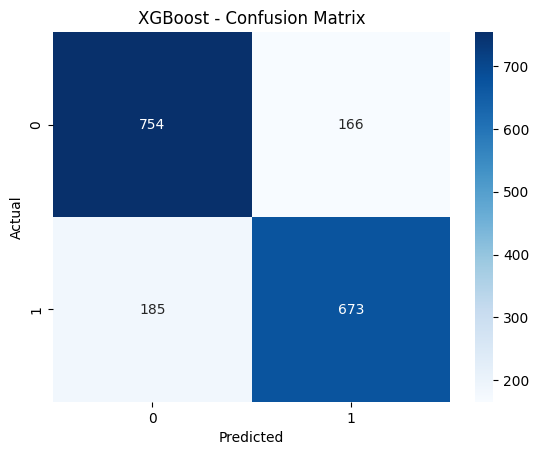

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report (XGBoost):")
print(classification_report(y_test, xgb_y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, xgb_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost - Confusion Matrix")
plt.show()


### Train model with DecisionTreeClassifier

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       920
           1       0.72      0.74      0.73       858

    accuracy                           0.74      1778
   macro avg       0.74      0.74      0.74      1778
weighted avg       0.74      0.74      0.74      1778



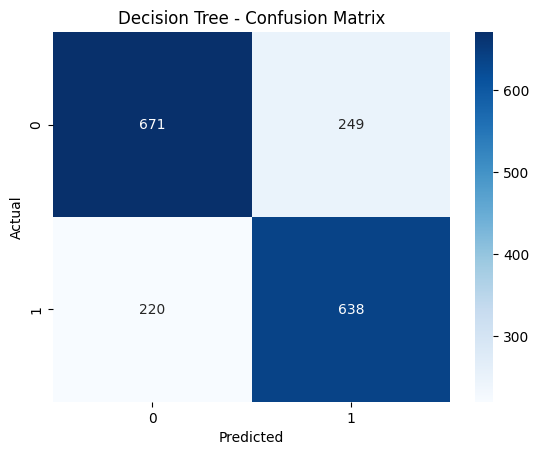

Accuracy: 0.7362204724409449


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Khởi tạo mô hình
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)

# Huấn luyện
dt_model.fit(X_train, y_train)

# Dự đoán trên tập test
dt_y_pred = dt_model.predict(X_test)

# Đánh giá kết quả
print("Classification Report (Decision Tree):")
print(classification_report(y_test, dt_y_pred))

# Ma trận nhầm lẫn
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, dt_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy
print("Accuracy:", accuracy_score(y_test, dt_y_pred))


Top 20 feature quan trọng:
                     Feature  Importance
4              reviews_count    0.343283
1                      added    0.136869
9                age_of_game    0.081106
121         tag_Free to Play    0.050895
2                   playtime    0.044642
3              ratings_count    0.020837
0                       year    0.014257
152          tag_Multiplayer    0.011916
7                  tag_count    0.011693
6                genre_count    0.008838
132     tag_In-App Purchases    0.008578
19               genre_Indie    0.007143
5             platform_count    0.006632
223                   tag_VR    0.006344
201   tag_Steam Leaderboards    0.005761
155              tag_Mystery    0.005740
30          platform_Android    0.005558
172                  tag_PvP    0.005392
206           tag_Story Rich    0.005322
246  tag_steam-trading-cards    0.005070


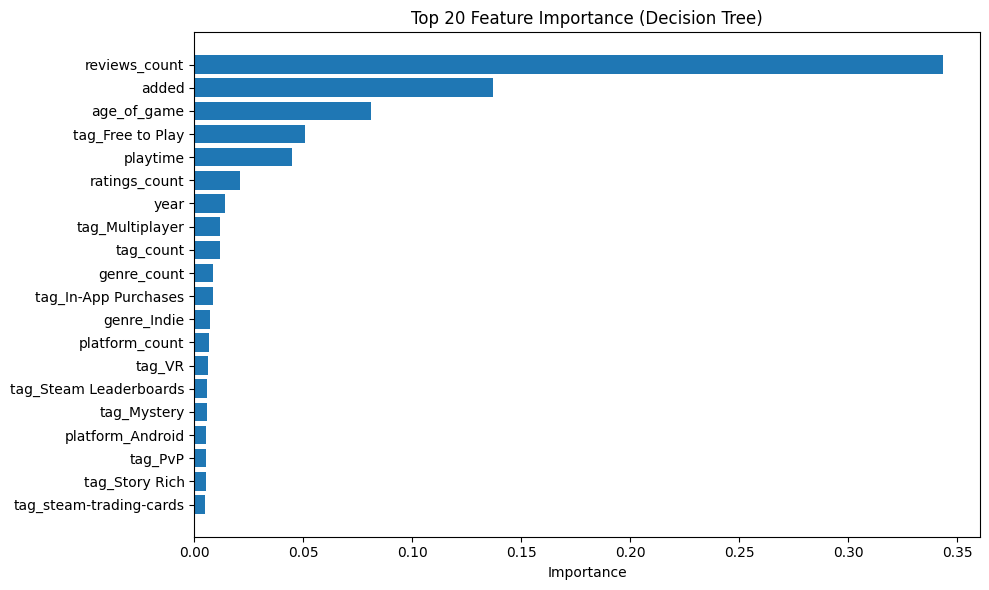

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Lấy importance
importances = dt_model.feature_importances_

# 2. Gắn tên cột cho dễ hiểu
feature_names = X_train.columns if hasattr(X_train, 'columns') else feature_cols
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 3. Hiển thị top 20
print("Top 20 feature quan trọng:")
print(feat_imp_df.head(20))

# 4. Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"][:20], feat_imp_df["Importance"][:20])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importance (Decision Tree)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


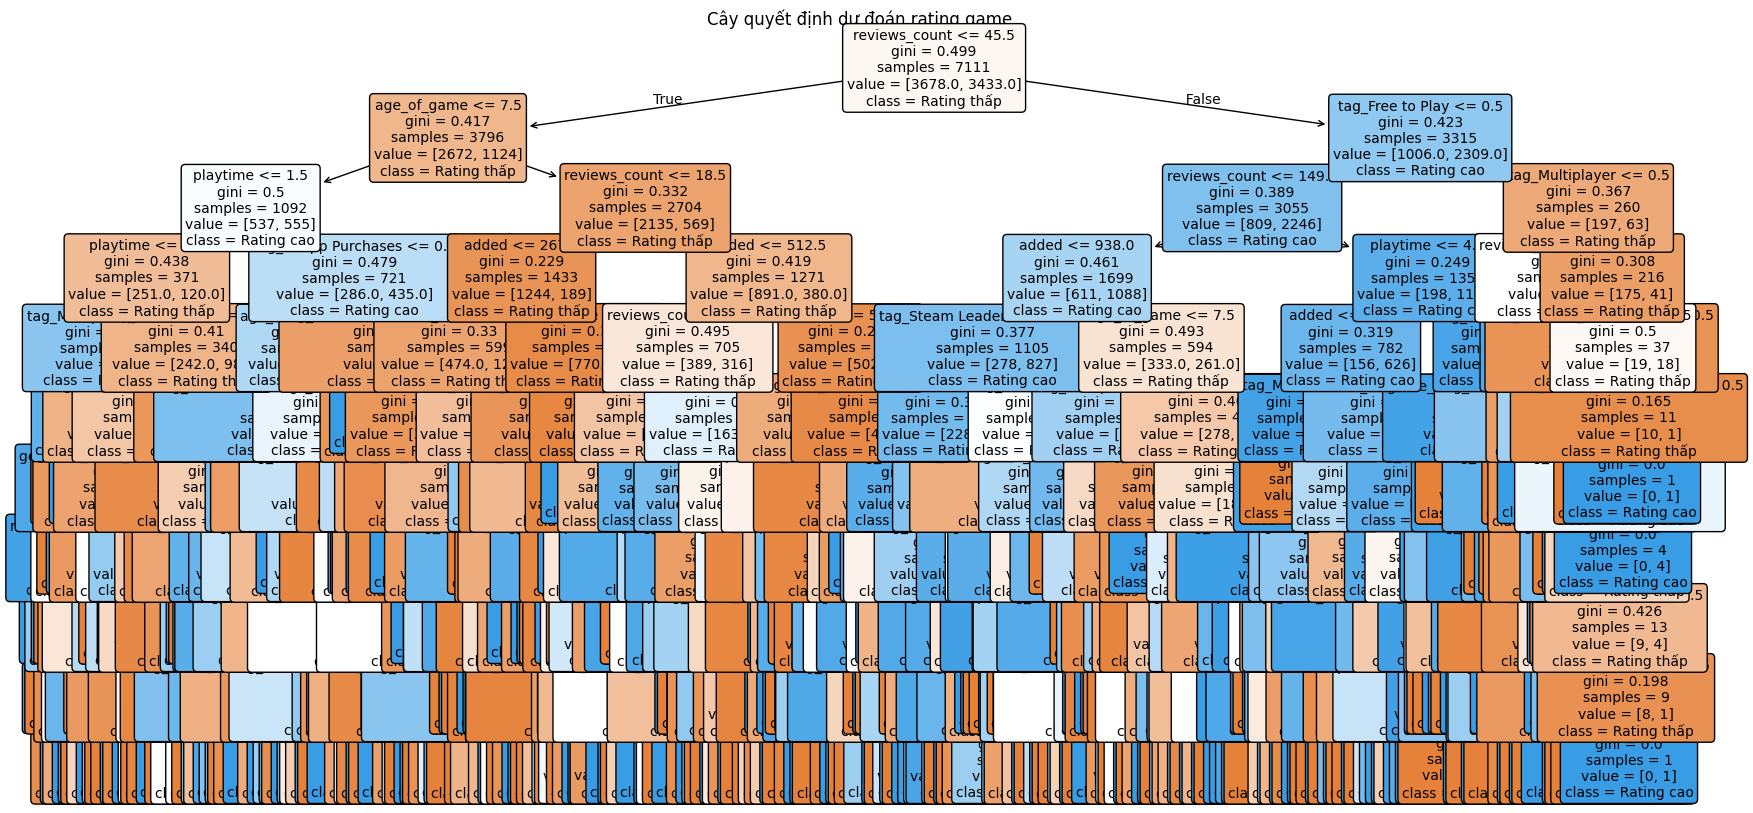

In [37]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X_train.columns,
    class_names=["Rating thấp", "Rating cao"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Cây quyết định dự đoán rating game")
plt.show()


## Lưu model đã huấn luyện

In [38]:
import joblib

# Lưu file
joblib.dump(xgb_model, "/content/drive/MyDrive/SIC_PROJECT/Model/xgb_model_rating.pkl")

print("Đã lưu model thành công.")


Đã lưu model thành công.
